In [1]:
import pandas as pd

In [3]:
# Load the CSV files
aqi = pd.read_csv('aqi.csv')
ev_sales = pd.read_csv('ev_sales.csv')
pg = pd.read_csv('pg.csv')
renew = pd.read_csv('renew.csv')

In [5]:
# Merge the dataframes on the "YM" column
merged_data1 = pd.merge(aqi, ev_sales, on="YM")
merged_data1 = pd.merge(merged_data1, pg, on="YM")
merged_data1 = pd.merge(merged_data1, renew, on="YM")

In [7]:
# Save the merged data to a new CSV file
merged_data1.to_csv('merged1.csv', index=False)

In [9]:
# Print the columns of the merged DataFrame
print("Columns of the merged DataFrame:")
print(merged_data1.columns)

Columns of the merged DataFrame:
Index(['YEAR_x', 'MONTH_x', 'YM', 'AQI', 'YEAR_y', 'MONTH_y', 'EV', 'Year',
       'Month', 'Thermal', 'Hydro', 'Nuclear', 'YEAR', 'MONTH', 'WIND',
       'SOLAR', 'BIOMASS', 'BAGASSE', 'SMALL HYDRO', 'OTHER', 'TOTAL_RENEW'],
      dtype='object')


In [11]:
# Rearrange columns
column_order = ['Year', 'Month', 'YM', 'AQI', 'EV', 'Thermal', 'Hydro', 'Nuclear', 'WIND', 'SOLAR', 'BIOMASS', 'BAGASSE', 'SMALL HYDRO', 'OTHER', 'TOTAL_RENEW']
merged_data1 = merged_data1[column_order]

# Save the merged data to a new CSV file
merged_data1.to_csv('merged_updated1.csv', index=False)

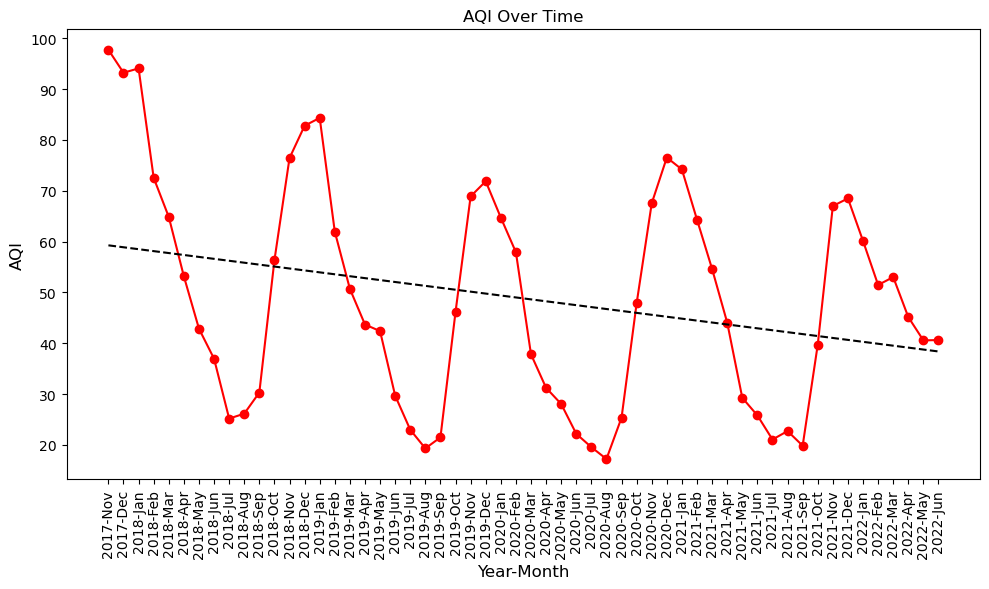

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the merged data
merged_data = pd.read_csv('merged_updated1.csv')

# Map month names to their abbreviated representation
month_map = {
    'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr', 'May': 'May', 'June': 'Jun',
    'July': 'Jul', 'August': 'Aug', 'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'
}

# Convert 'Month' column to abbreviated month names
merged_data['Month'] = merged_data['Month'].map(month_map)

# Create a new column combining 'Year' and 'Month' with a hyphen
merged_data['Year-Month'] = merged_data['Year'].astype(str) + '-' + merged_data['Month']

# Plotting
plt.figure(figsize=(10, 6))

# Plot the solid line for actual data
plt.plot(merged_data['Year-Month'], merged_data['AQI'], marker='o', color='red', linestyle='-')

# Fit a trendline using numpy.polyfit
x = np.arange(len(merged_data))
fit = np.polyfit(x, merged_data['AQI'], 1)
trendline = fit[0] * x + fit[1]

# Plot the trendline (black and dotted)
plt.plot(merged_data['Year-Month'], trendline, color='black', linestyle='--')

# Title and labels
plt.title('AQI Over Time')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('AQI', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=10)

# Remove grid lines
plt.grid(False)

# Save plot as an image file
plt.savefig('aqi_trendline_plot.png')

# Show plot
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
# Load the dataset
merged_data = pd.read_csv('merged_updated1.csv')

In [21]:
# Fix any incorrect entries and map full month names to their abbreviated version
month_map = {
    'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr', 'May': 'May', 'June': 'Jun',
    'July': 'Jul', 'August': 'Aug', 'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec',
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Apr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Aug': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dec': 'Dec'
}

# Apply the mapping to the 'Month' column
merged_data['Month'] = merged_data['Month'].map(month_map)

# Now, convert 'Year' and 'Month' to a datetime object
merged_data['Year-Month'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' + merged_data['Month'], format='%Y-%b')

# Check if the conversion worked properly
print(merged_data[['Year', 'Month', 'Year-Month']].head())


   Year Month Year-Month
0  2017   Nov 2017-11-01
1  2017   Dec 2017-12-01
2  2018   Jan 2018-01-01
3  2018   Feb 2018-02-01
4  2018   Mar 2018-03-01


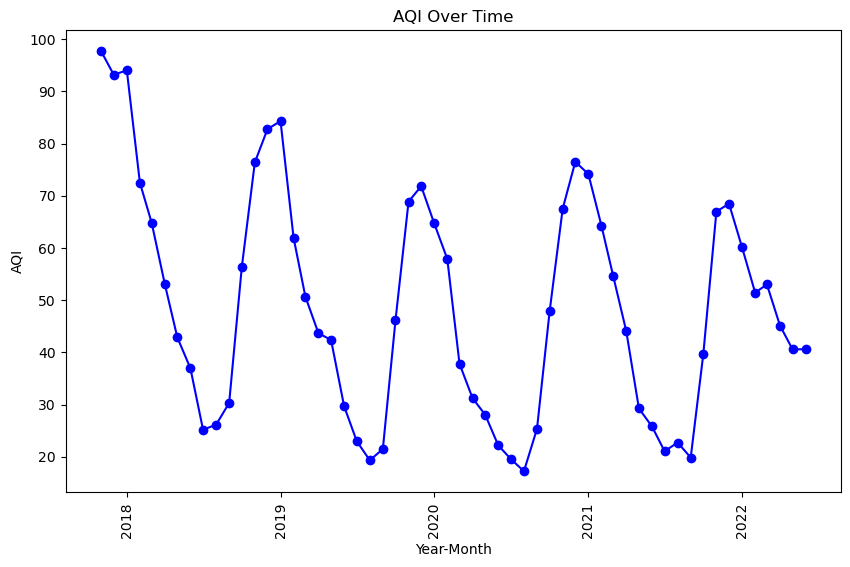

In [23]:
# Set 'Year-Month' as the index
merged_data.set_index('Year-Month', inplace=True)

# Visualize the AQI data
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['AQI'], color='blue', marker='o')
plt.title('AQI Over Time')
plt.xlabel('Year-Month')
plt.ylabel('AQI')
plt.xticks(rotation=90)
plt.show()

In [25]:
# Step 1: Test for stationarity using Augmented Dickey-Fuller test
# ADF test to check if differencing is needed (d term in SARIMA)
result = adfuller(merged_data['AQI'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.267560
p-value: 0.182644


In [27]:
# Check if p-value > 0.05, if so the data is non-stationary and needs differencing
# If the data is non-stationary, we proceed to differencing

In [29]:
# Step 2: Differencing (non-seasonal and seasonal)
# If non-stationary, difference the data to remove trend (d=1)
merged_data['AQI_diff'] = merged_data['AQI'].diff().dropna()

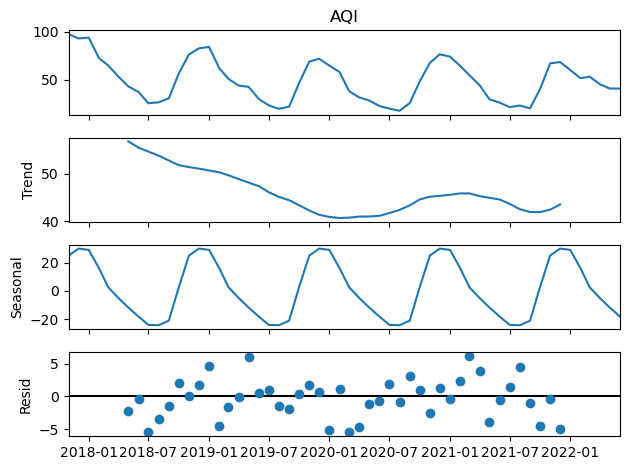

In [31]:
# Seasonal decomposition to check for seasonality (can help identify seasonal period 'm')
decomposition = seasonal_decompose(merged_data['AQI'], model='additive', period=12)
decomposition.plot()
plt.show()

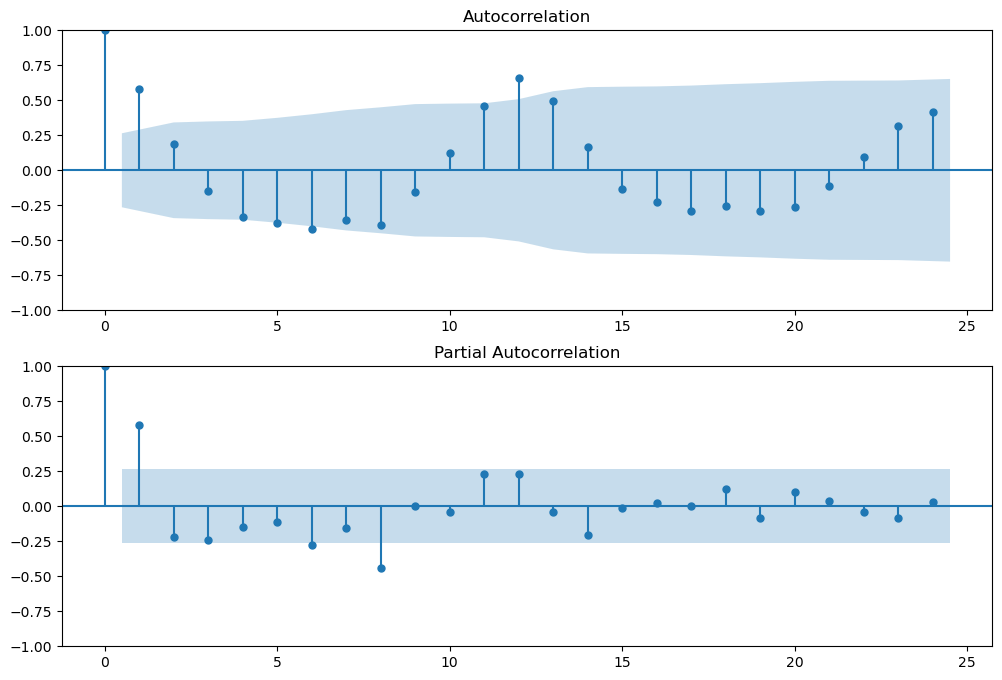

In [32]:
# Step 3: Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots
# This helps us determine p and q values
fig, ax = plt.subplots(2, 1, figsize=(12,8))

plot_acf(merged_data['AQI_diff'].dropna(), lags=24, ax=ax[0])
plot_pacf(merged_data['AQI_diff'].dropna(), lags=24, ax=ax[1])
plt.show()

In [35]:
# Step 4: Fit the SARIMA model
# From the ACF and PACF plots and based on the seasonal decomposition, we choose the following parameters:
# Assuming we found (p=1, d=1, q=1), and (P=1, D=1, Q=1, m=12) for seasonal terms

# SARIMA(p,d,q)(P,D,Q)m model fitting
sarima_model = SARIMAX(merged_data['AQI'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [37]:
# Print the model summary
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                AQI   No. Observations:                   56
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -137.108
Date:                            Fri, 13 Sep 2024   AIC                            284.217
Time:                                    22:21:18   BIC                            293.023
Sample:                                11-01-2017   HQIC                           287.464
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0002      0.850     -0.000      1.000      -1.667       1.666
ma.L1         -0.2295      0.860   

C:\Users\ACER\AppData\Local\Temp\ipykernel_16112\2988842181.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=merged_data.index[-1], periods=forecast_steps + 1, freq='M')[1:]


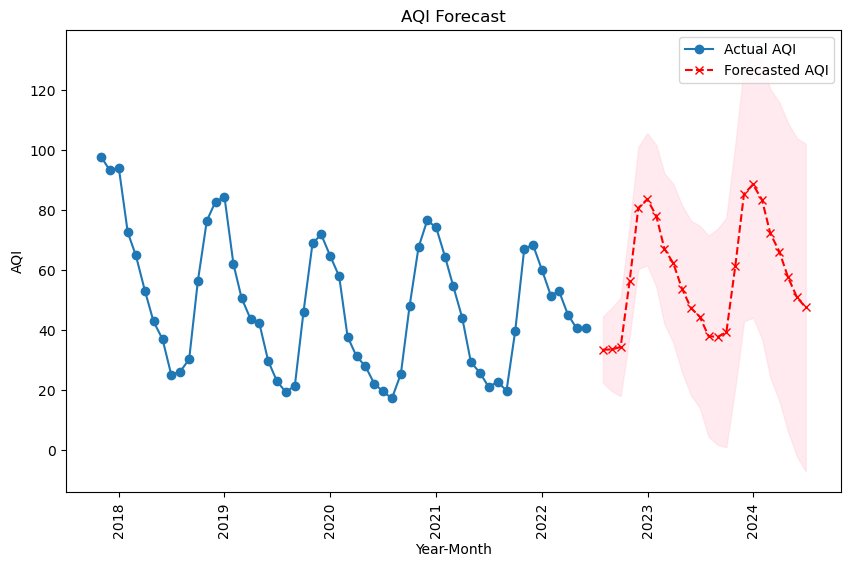

SARIMA(1, 1, 1)(1, 1, 1, 12)


In [39]:
# Step 5: Forecast future values
# Let's forecast the next 24 months
forecast_steps = 24
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=merged_data.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot the forecasted values along with the historical data
plt.figure(figsize=(10, 6))
plt.plot(merged_data.index, merged_data['AQI'], label='Actual AQI', marker='o')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted AQI', color='red', linestyle='--', marker='x')

plt.fill_between(forecast_index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='pink', alpha=0.3)

plt.title('AQI Forecast')
plt.xlabel('Year-Month')
plt.ylabel('AQI')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Step 6: Print the SARIMA equation
print(f"SARIMA(1, 1, 1)(1, 1, 1, 12)")